In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
from linearmodels.panel import compare
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy import stats

In [2]:
# Load the data
df = pd.read_csv('politicules_values_df_clean_final.csv')

In [3]:
# Ensure the data is in long format and inspect it
print(df.head())

  COUNTRY_ALPHA  wave  value  proportion variable  mean_value
0           ALB     3    1.0    0.082745     E023         NaN
1           ALB     3    2.0    0.283552     E023         NaN
2           ALB     3    3.0    0.394551     E023         NaN
3           ALB     3    4.0    0.239152     E023         NaN
4           ALB     4    1.0    0.117234     E023         NaN


In [4]:
# Pivot the data to long format
df_long = df.pivot_table(
    index=['COUNTRY_ALPHA', 'wave'],  # Rows: country-wave combinations
    columns='variable',               # Columns: variables (E023, A006, etc.)
    values='proportion',              # Values: proportions
    aggfunc='first'                   # Use the first value if there are duplicates
).reset_index()

# Check the result
print(df_long.head())

variable COUNTRY_ALPHA  wave      A001      A006      A008      D059  \
0                  ALB     3  0.962777  0.247951  0.032058  0.357143   
1                  ALB     4  0.960922  0.280326  0.097684  0.178455   
2                  AND     5  0.868395  0.079000  0.284855  0.008138   
3                  AND     7  0.895418  0.094810  0.342629  0.027245   
4                  ARG     1       NaN       NaN  0.171429       NaN   

variable      E012      E023   E069_11   E069_12      E114      E124      G006  
0         0.186416  0.082745  0.043621  0.014448  0.178484       NaN  0.566316  
1         0.282523  0.117234  0.181358  0.040041  0.068584  0.033846  0.726166  
2         0.589139  0.093812  0.032323  0.008065  0.013598  0.162298  0.396425  
3         0.551449  0.151606  0.072289  0.026369  0.114343  0.389389  0.545073  
4         0.406536  0.091365       NaN       NaN       NaN       NaN  0.491024  


In [5]:
# If not, you can extract them from the original DataFrame
continuous_vars = df[df['variable'].isin(['F063', 'E033'])].pivot_table(
    index=['COUNTRY_ALPHA', 'wave'],
    columns='variable',
    values='mean_value',  # Use mean_value for continuous variables
    aggfunc='first'
).reset_index()

# Merge continuous variables into the long format DataFrame
df_long = pd.merge(df_long, continuous_vars, on=['COUNTRY_ALPHA', 'wave'], how='left')

# Check the result
print(df_long.head())

variable COUNTRY_ALPHA  wave      A001      A006      A008      D059  \
0                  ALB     3  0.962777  0.247951  0.032058  0.357143   
1                  ALB     4  0.960922  0.280326  0.097684  0.178455   
2                  AND     5  0.868395  0.079000  0.284855  0.008138   
3                  AND     7  0.895418  0.094810  0.342629  0.027245   
4                  ARG     1       NaN       NaN  0.171429       NaN   

variable      E012      E023   E069_11   E069_12      E114      E124  \
0         0.186416  0.082745  0.043621  0.014448  0.178484       NaN   
1         0.282523  0.117234  0.181358  0.040041  0.068584  0.033846   
2         0.589139  0.093812  0.032323  0.008065  0.013598  0.162298   
3         0.551449  0.151606  0.072289  0.026369  0.114343  0.389389   
4         0.406536  0.091365       NaN       NaN       NaN       NaN   

variable      G006      E033      F063  
0         0.566316  5.069490  7.077789  
1         0.726166  5.340717  7.341117  
2         0

In [6]:
# Set multi-index
df_long = df_long.set_index(['COUNTRY_ALPHA', 'wave'])

# Check the result
print(df_long.head())

variable                A001      A006      A008      D059      E012  \
COUNTRY_ALPHA wave                                                     
ALB           3     0.962777  0.247951  0.032058  0.357143  0.186416   
              4     0.960922  0.280326  0.097684  0.178455  0.282523   
AND           5     0.868395  0.079000  0.284855  0.008138  0.589139   
              7     0.895418  0.094810  0.342629  0.027245  0.551449   
ARG           1          NaN       NaN  0.171429       NaN  0.406536   

variable                E023   E069_11   E069_12      E114      E124  \
COUNTRY_ALPHA wave                                                     
ALB           3     0.082745  0.043621  0.014448  0.178484       NaN   
              4     0.117234  0.181358  0.040041  0.068584  0.033846   
AND           5     0.093812  0.032323  0.008065  0.013598  0.162298   
              7     0.151606  0.072289  0.026369  0.114343  0.389389   
ARG           1     0.091365       NaN       NaN       NaN     

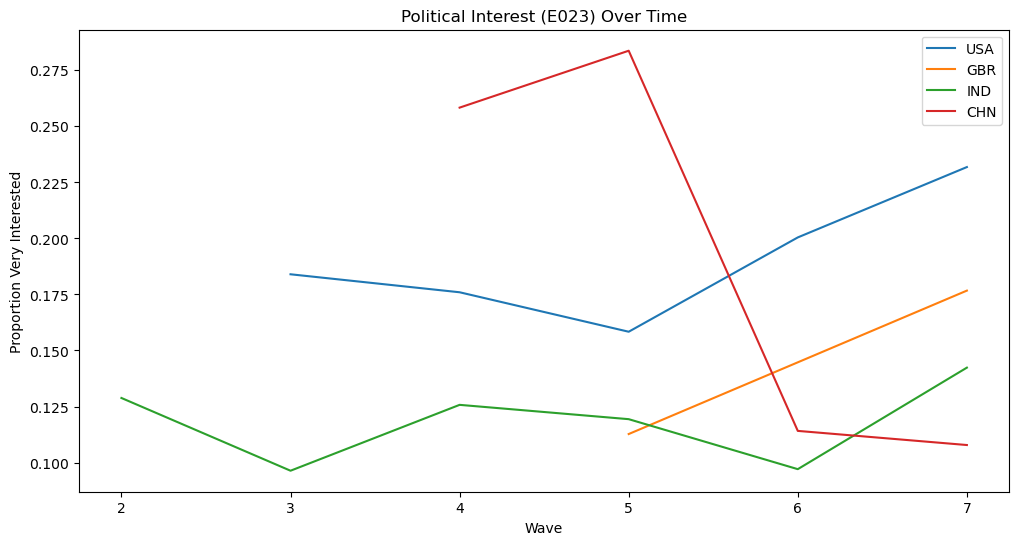

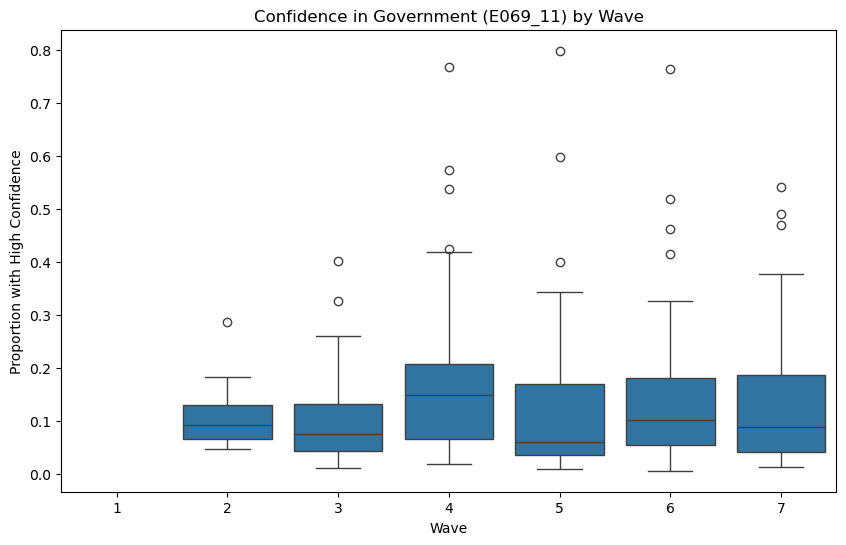

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Plotting political interest (E023) over time for a few countries
countries_to_plot = ['USA', 'GBR', 'IND', 'CHN']  # Example countries
plt.figure(figsize=(12, 6))
for country in countries_to_plot:
    country_data = df_long.loc[country]
    plt.plot(country_data.index.get_level_values('wave'), country_data['E023'], label=country)
plt.title('Political Interest (E023) Over Time')
plt.xlabel('Wave')
plt.ylabel('Proportion Very Interested')
plt.legend()
plt.show()

# Example: Boxplot of confidence in government (E069_11) by wave
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_long.index.get_level_values('wave'), y=df_long['E069_11'])
plt.title('Confidence in Government (E069_11) by Wave')
plt.xlabel('Wave')
plt.ylabel('Proportion with High Confidence')
plt.show()

In [8]:
import statsmodels.api as sm

# Define dependent and independent variables
dependent_var = 'E023'  # Political Interest
independent_vars = ['A006', 'A001', 'F063', 'E033']  # Example independent variables

# Add a constant to the independent variables
X = sm.add_constant(df_long[independent_vars])
y = df_long[dependent_var]

# Run Pooled OLS
pooled_ols = sm.OLS(y, X, missing='drop').fit()
print(pooled_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                   E023   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     5.732
Date:                Tue, 18 Mar 2025   Prob (F-statistic):           0.000198
Time:                        07:40:41   Log-Likelihood:                 346.56
No. Observations:                 257   AIC:                            -683.1
Df Residuals:                     252   BIC:                            -665.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1737      0.076      2.277      0.0

In [9]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from linearmodels.panel import PanelOLS, compare

# Assuming df_long is your long-format DataFrame
# Define dependent and independent variables
dependent_var = 'E023'  # Political Interest
independent_vars = ['A006', 'A001', 'F063', 'E033']  # Example independent variables

# Add a constant to the independent variables
X = sm.add_constant(df_long[independent_vars])
y = df_long[dependent_var]

# Check for missing or infinite values
print("Missing values in X:")
print(X.isnull().sum())

print("\nMissing values in y:")
print(y.isnull().sum())

print("\nInfinite values in X:")
print(np.isinf(X).sum())

print("\nInfinite values in y:")
print(np.isinf(y).sum())

# Drop rows with missing values in X or y
df_clean = df_long.dropna(subset=independent_vars + [dependent_var])

# Rebuild X and y after dropping missing values
X = sm.add_constant(df_clean[independent_vars])
y = df_clean[dependent_var]

# Run Pooled OLS
pooled_ols = sm.OLS(y, X, missing='drop').fit()
print(pooled_ols.summary())

# Run Breusch-Pagan test
residuals = pooled_ols.resid
bp_test = het_breuschpagan(residuals, X)
print(f"Breusch-Pagan Test Statistic: {bp_test[0]}")
print(f"P-value: {bp_test[1]}")

Missing values in X:
const     0
A006     11
A001     11
F063     11
E033     32
dtype: int64

Missing values in y:
6

Infinite values in X:
const    0
A006     0
A001     0
F063     0
E033     0
dtype: int64

Infinite values in y:
0
                            OLS Regression Results                            
Dep. Variable:                   E023   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     5.732
Date:                Tue, 18 Mar 2025   Prob (F-statistic):           0.000198
Time:                        07:40:41   Log-Likelihood:                 346.56
No. Observations:                 257   AIC:                            -683.1
Df Residuals:                     252   BIC:                            -665.4
Df Model:                           4                                         
Covariance Type:            nonrobust                  

In [20]:
print(df_long.head())

   level_0 COUNTRY_ALPHA  index      A001      A006      A008      D059  \
0        0           ALB      0  0.962777  0.247951  0.032058  0.357143   
1        1           ALB      1  0.960922  0.280326  0.097684  0.178455   
2        2           AND      2  0.868395  0.079000  0.284855  0.008138   
3        3           AND      3  0.895418  0.094810  0.342629  0.027245   
4        4           ARG      4       NaN       NaN  0.171429       NaN   

       E012      E023   E069_11  ...      E124      G006      E033      F063  \
0  0.186416  0.082745  0.043621  ...       NaN  0.566316  5.069490  7.077789   
1  0.282523  0.117234  0.181358  ...  0.033846  0.726166  5.340717  7.341117   
2  0.589139  0.093812  0.032323  ...  0.162298  0.396425  4.638858  5.357789   
3  0.551449  0.151606  0.072289  ...  0.389389  0.545073  4.857612  4.763052   
4  0.406536  0.091365       NaN  ...       NaN  0.491024  5.261830  7.001032   

   wave_2  wave_3  wave_4  wave_5  wave_6  wave_7  
0   False    Tru

In [10]:
# Reset index to ensure 'wave' is accessible as a column
df_long = df_long.reset_index()
print(df_long.head())

variable COUNTRY_ALPHA  wave      A001      A006      A008      D059  \
0                  ALB     3  0.962777  0.247951  0.032058  0.357143   
1                  ALB     4  0.960922  0.280326  0.097684  0.178455   
2                  AND     5  0.868395  0.079000  0.284855  0.008138   
3                  AND     7  0.895418  0.094810  0.342629  0.027245   
4                  ARG     1       NaN       NaN  0.171429       NaN   

variable      E012      E023   E069_11   E069_12      E114      E124  \
0         0.186416  0.082745  0.043621  0.014448  0.178484       NaN   
1         0.282523  0.117234  0.181358  0.040041  0.068584  0.033846   
2         0.589139  0.093812  0.032323  0.008065  0.013598  0.162298   
3         0.551449  0.151606  0.072289  0.026369  0.114343  0.389389   
4         0.406536  0.091365       NaN       NaN       NaN       NaN   

variable      G006      E033      F063  
0         0.566316  5.069490  7.077789  
1         0.726166  5.340717  7.341117  
2         0

In [14]:
# Reset index to make 'wave' a column (if it's in the index)
if 'wave' in df_long.index.names:
    df_long = df_long.reset_index()

# Ensure 'wave' is a column before creating dummies
if 'wave' not in df_long.columns:
    raise KeyError("Column 'wave' not found in dataset!")

# Convert 'wave' to string before creating dummies
df_long['wave'] = df_long['wave'].astype(str)

# Create wave dummies
df_long = pd.get_dummies(df_long, columns=['wave'], drop_first=True)

# Set multi-index again (excluding wave since it's now dummies)
df_long = df_long.set_index(['COUNTRY_ALPHA'])

# Define independent variables including wave dummies
independent_vars_fe = independent_vars + [col for col in df_long.columns if col.startswith('wave_')]

# Ensure dependent variable exists
if dependent_var not in df_long.columns:
    raise KeyError(f"Dependent variable '{dependent_var}' not found in dataset!")

# Run Fixed Effects Model
fe_model = PanelOLS(df_long[dependent_var], df_long[independent_vars_fe], entity_effects=True).fit()
print(fe_model.summary)


KeyError: "Column 'wave' not found in dataset!"

In [16]:
from linearmodels.panel import compare

# Run Random Effects Model
re_model = PanelOLS(df_long[dependent_var], df_long[independent_vars_fe]).fit()

# Perform Hausman Test
hausman_test = compare(fe_model, re_model)
print(hausman_test)

# Interpretation: If the Hausman test is significant (p-value < 0.05), use the fixed-effects model. Otherwise, use the random-effects model.

ValueError: Series can only be used with a 2-level MultiIndex

In [ ]:
if hausman_test.pvalue < 0.05:
    print("Use Fixed Effects Model")
    final_model = fe_model
else:
    print("Use Random Effects Model")
    final_model = re_model

# Print final model summary
print(final_model.summary)